In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
data = pd.read_csv("./digit_data.csv")

In [62]:
data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
data["label"]

0        1
1        0
2        1
3        4
4        0
        ..
41995    0
41996    1
41997    7
41998    6
41999    9
Name: label, Length: 42000, dtype: int64

In [66]:
df = pd.get_dummies(data["label"], dtype=int)

In [67]:
df

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
41995,1,0,0,0,0,0,0,0,0,0
41996,0,1,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,1,0,0
41998,0,0,0,0,0,0,1,0,0,0


In [69]:
data_encoded = pd.concat([data,df], axis = 1)

In [72]:
data_encoded = data_encoded.drop(["label"], axis =1)

In [73]:
data_encoded

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
41996,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
41997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
41998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [77]:
data_encoded.iloc[1, :784]

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Name: 1, Length: 784, dtype: int64

In [78]:
np.array(data_encoded.iloc[1, :784]).reshape((28,28))

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  18,  30, 137,
        137, 192,  86,  72,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  13,  86, 250, 254, 254,
        254, 254, 217, 246, 151,  32,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

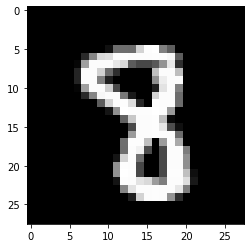

In [80]:
plt.imshow(np.array(data.iloc[int(np.random.random() * data.shape[0]), 1:]).reshape((28,28)), cmap="gray")

In [81]:
data_encoded = np.array(data_encoded)
m, n = data_encoded.shape

In [84]:
m,n

(42000, 794)

In [85]:
np.random.shuffle(data_encoded)

In [86]:
data_test = data_encoded[:1000]
test_y = data_test[:, 784:]
test_x = data_test[:,:784]

In [88]:
test_x.shape

(1000, 784)

In [89]:
test_y

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [91]:
data_train = data_encoded[1000:] #.T
train_y = data_train[:, 784:]
train_x = data_train[:,:784]

In [92]:
train_x[0].shape

(784,)

In [93]:
train_x

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [94]:
np.random.seed(0)

In [105]:

def ReLU(inputs):
    return np.maximum(0, inputs)

def ReLU_derivative(inputs):
    return (inputs > 0) * 1
        
def Sigmoid(inputs):
    return (1 / 1 + np.exp(-inputs))
    
def Sigmoid_derivative(inputs):
    return (1 / 1 + np.exp(-inputs))*(1- (1 / 1 + np.exp(-inputs)))

def SoftMax(inputs):
    exp_values = np.exp(inputs - np.max(inputs, axis = 1, keepdims = True))
    return exp_values/ np.sum(exp_values)


def SoftMax_derivative(inputs):
    exp_shifted = np.exp(x - x.max())
    return exp_shifted / np.sum(exp_shifted, axis = 0) * (1 - exp_shifted / np.sum(exp_shifted, axis = 0))


Coursera Implementation

In [5]:
np.random.seed(0)

In [178]:
def initialize_parameters(layer_dims):
    """Layer dims contains the dimension of each layer in the neural network"""
    parameters = {}

    num_layers = len(layer_dims) # as the input layer is taken as 0
    for i in range(1, num_layers):
        parameters[f"w{i}"] = (np.random.random((layer_dims[i-1], layer_dims[i])) - 0.5).T
        parameters[f"b{i}"] = (np.random.random((1, layer_dims[i])) - 0.5).T

    return parameters


In [179]:
train_x[0].shape[0]

784

In [180]:
train_y[0].shape[0]

10

In [181]:
layer_sizes = [train_x[0].shape[0], 10,train_y[0].shape[0]]
parameters = initialize_parameters(layer_sizes)

In [182]:
parameters["w1"].shape

(10, 784)

In [184]:
parameters["b1"].shape

(10, 1)

In [186]:
def forward_pass(X, parameters):
    
    w1 = parameters["w1"] # (10, 784)
    w2 = parameters["w2"] # (10, 10)
    b1 = parameters["b1"] # (10, 1)
    b2 = parameters["b2"] # (10, 1)
    
    Z1 = np.matmul(w1, X).reshape(-1,1)

    
    Z1 += b1
    A1 = ReLU(Z1)    
    
    Z2 = np.matmul(w2, A1).reshape(-1,1)
    Z2 += b2
    

    
    A2 = Softmax(Z2)
    
    cache = {
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2, 
        "A2": A2
    }
    return cache

In [187]:
def backprop(X, y, parameters, cache, alpha=0.01):
    
    m = y.shape[1]
    Z1, A1, Z2, A2 = cache
    W1, _, W2, _ = parameters

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients

In [188]:
def update_parameters(parameters, gradients, learning_rate):
    w1, b1, w2, b2 = parameters
    dW1, db1, dW2, db2 = gradients

    w1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    w2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    return {"W1": w1, "b1": b1, "W2": w2, "b2": b2}

In [190]:
def cross_entropy_loss(Y_pred, Y_true):
    m = Y_true.shape[1]
    loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
    return loss

In [191]:
def relu(z):
    return np.maximum(0, z)

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True)) # For numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [189]:
def train(X, Y, hidden_size, output_size, learning_rate, epochs):
    input_size = X.shape[0]
    parameters = initialize_parameters(input_size, hidden_size, output_size)

    for epoch in range(epochs):
        cache = forward_pass(X, parameters)
        loss = cross_entropy_loss(cache[3], Y)
        gradients = backward_pass(X, Y, parameters, cache)
        parameters = update_parameters(parameters, gradients, learning_rate)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return parameters

In [ ]:
trained_parameters = train(X, Y, hidden_size, output_size, learning_rate, epochs)
predictions = predict(X, trained_parameters)

In [138]:
def categorical_cross_entropy(y_true, y_pred):
    loss = 0
    
    for true, pred in zip(y_true, y_pred):
        loss = loss + (-true) * np.log(pred)
        
    return loss

In [140]:
from tqdm import tqdm

In [141]:
epochs = 5
t_rate = 0.001
# train
print('################### training ####################')
for e in range(epochs):
    print('epoch:', e)
    
    samples = train_x.shape[0]
    cost = 0
    hit_count = 0
    for i in tqdm(range(samples)):
        m_state = backward_pass(train_x[i], train_y[i])
        # add partial cost
        cost += categorical_cross_entropy(m_state['o3'], y_train[i])
        
        # stochastic gradient descent
        # update weights
        model['w0'] -= t_rate * m_state['D0']
        model['w1'] -= t_rate * m_state['D1']
        model['w2'] -= t_rate * m_state['D2']
        
        if np.argmax(m_state['o3']) == np.argmax(y_train[i]):
            # successful detection
            hit_count += 1
# performance evaluation
    cost = cost / samples
    accuracy = hit_count / samples
    print('cost:', cost, 'accuracy:', accuracy)
# save the model

################### training ####################
epoch: 0


  0%|          | 0/41000 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_23812\3784884760.py:8: RuntimeWarning: overflow encountered in exp
  return (1 / 1 + np.exp(-inputs))
  0%|          | 0/41000 [00:00<?, ?it/s]


ValueError: shapes (10,64) and (784,) not aligned: 64 (dim 1) != 784 (dim 0)

Aayush

In [ ]:
def initialize_parameters(random_state=None):
    np.random.seed(random_state)
    w_1 = np.random.random((100, 28*28)) * 0.01 - 0.005
    b_1 = (np.random.random((100,)) * 0.01 - 0.005).reshape(-1,1)
    w_2 = np.random.random((10, 100)) * 0.01 - 0.005
    b_2 = (np.random.random((10,)) * 0.01 - 0.005).reshape(-1,1)
    
    
    params = {
        "w_1": w_1,
        "w_2": w_2,
        "b_1": b_1,
        "b_2": b_2
    }
    return params

def ReLU(X):
    # shape = X.shape
    # temp = X.reshape(-1,1)
    # for i in range(len(temp)):
    #     temp[i] = max(0, temp[i])
        
    # temp = temp.reshape(shape)
    # return temp
    return np.maximum(X, np.zeros(X.shape))

def d_ReLU(X):
    return X >= 0

def Softmax(x):
    # x = x / 100
    x = np.float128(x)
    # print(np.exp(x) / np.exp(x).sum())
    return np.exp(x) / np.exp(x).sum()

def categorical_cross_entropy(y_true, y_pred):
    
    loss = 0
    
    for true, pred in zip(y_true, y_pred):
        loss = loss + (-true) * np.log(pred)
        
    return loss
    

def forward(X, params):
    
    # X.shape = (784,1)
    w_1 = params["w_1"] # (10, 784)
    w_2 = params["w_2"] # (10, 10)
    b_1 = params["b_1"] # (10, 1)
    b_2 = params["b_2"] # (10, 1)
    
    z_1 = np.matmul(w_1, X).reshape(-1,1)
    # print(z_1.shape, b_1.shape)
    
    z_1 += b_1
    a_1 = ReLU(z_1)    
    
    z_2 = np.matmul(w_2, a_1).reshape(-1,1)
    z_2 += b_2
    
    # print(z_2.shape)
    # z_2 = np.sqrt(np.abs(z_2))
    
    
    out = Softmax(z_2)
    
    cache = {
        "z_1": z_1,
        "a_1": a_1,
        "z_2": z_2, 
        "a_2": out
    }
    return out, cache



def backprop(X, y, params, cache, lr=0.01):
    
    # X: (784,) y: (10, 1)
    
    m = 1

    z_1, a_1, z_2, a_2 = cache["z_1"].reshape(-1, 1), cache["a_1"].reshape(-1, 1), cache["z_2"].reshape(-1, 1), cache["a_2"].reshape(-1, 1)  # (10,)
    
    
    w_1 = params["w_1"] # (10, 784)
    w_2 = params["w_2"] # (10,10)
    b_1 = params["b_1"].reshape(-1, 1) # (10,1)
    b_2 = params["b_2"].reshape(-1, 1) # (10,1)
    
    # print(f"X: {X.shape}\ny: {y.shape}\nw_1: {w_1.shape}\nb_1: {b_1.shape}\nw_2: {w_2.shape}\nb_2: {b_2.shape}\nz_1: {z_1.shape}\na_1: {a_1.shape}\nz_2: {z_2.shape}\na_2: {a_2.shape}")
    
    dz_2 = a_2 - y # (10,)
    # print(f"dz_2: {dz_2.shape}")
    dw_2 = np.matmul(dz_2, a_1.T) / m # (10,) * (1,10) = (10,10)
    # print(f"dw_2: {dw_2.shape}")
    db_2 = np.sum(dz_2, axis=1, keepdims=True) / m # ()
    # print(f"db_2: {db_2.shape}")
    
    dz_1 = np.multiply(np.matmul(w_2.T, dz_2), d_ReLU(z_1))
    # print(f"dz_1: {dz_1.shape}")
    db_1 = np.sum(dz_1, axis=1, keepdims=True) / m
    # print(f"db_1: {db_1.shape}")
    dw_1 = np.matmul(dz_1, X.T) / m
    # print(f"dw_1: {dw_1.shape}")
    
    w_1 = w_1 - lr * dw_1
    w_2 = w_2 - lr * dw_2
    b_1 = b_1 - lr * db_1
    b_2 = b_2 - lr * db_2
    
    params = {
        "w_1": w_1,
        "w_2": w_2,
        "b_1": b_1,
        "b_2": b_2
    }
    
    # print(f"w_1: {w_1.shape}\nb_1: {b_1.shape}\nw_2: {w_2.shape}\nb_2: {b_2.shape}")
    
    
    return params
    
def fit(X, y, iter=30, lr=0.01):
    params = initialize_parameters()
    
    m = X.shape[1]
    
    for i in range(iter):
        loss = 0
        for i in tqdm(range(m)):
            # print(X[:, i].shape, y[:, i])
            out, cache = forward(X[:, i], params)
            
            params = backprop(X[:, i].reshape(-1, 1), y[:, i].reshape(-1,1), params, cache, lr=lr)
            
            # print(y[:,i].shape, out.shape)
            
            loss += categorical_cross_entropy(y[:, i], out)
        
        print("loss: ", loss/m)
    
    return params

GPT

In [ ]:
import numpy as np

# Function to initialize the parameters of the neural network
def initialize_parameters(input_size, hidden_size, output_size):
    np.random.seed(42)
    # Initialize the weights and biases for the first hidden layer
    W1 = np.random.randn(hidden_size, input_size) * 0.01
    b1 = np.zeros((hidden_size, 1))
    # Initialize the weights and biases for the output layer
    W2 = np.random.randn(output_size, hidden_size) * 0.01
    b2 = np.zeros((output_size, 1))
    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

# ReLU activation function
def relu(z):
    return np.maximum(0, z)

# Softmax activation function for the output layer
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True)) # For numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

# Function for the forward pass of the neural network
def forward_pass(X, parameters):
    W1, b1, W2, b2 = parameters
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Function to predict the output labels for given input features
def predict(X, parameters):
    _, _, _, A2 = forward_pass(X, parameters)
    return np.argmax(A2, axis=0)

# Cross-entropy loss function
def cross_entropy_loss(Y_pred, Y_true):
    m = Y_true.shape[1]
    loss = -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m
    return loss

# Function for the backward pass to compute gradients
def backward_pass(X, Y, parameters, cache):
    m = Y.shape[1]
    Z1, A1, Z2, A2 = cache
    W1, _, W2, _ = parameters

    dZ2 = A2 - Y
    dW2 = np.dot(dZ2, A1.T) / m
    db2 = np.sum(dZ2, axis=1, keepdims=True) / m

    dA1 = np.dot(W2.T, dZ2)
    dZ1 = dA1 * (Z1 > 0)  # Derivative of ReLU
    dW1 = np.dot(dZ1, X.T) / m
    db1 = np.sum(dZ1, axis=1, keepdims=True) / m

    gradients = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    return gradients

# Function to update the parameters using gradient descent
def update_parameters(parameters, gradients, learning_rate):
    W1, b1, W2, b2 = parameters
    dW1, db1, dW2, db2 = gradients

    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2

    return {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

# Function to train the neural network
def train(X, Y, hidden_size, output_size, learning_rate, epochs):
    input_size = X.shape[0]
    parameters = initialize_parameters(input_size, hidden_size, output_size)

    for epoch in range(epochs):
        cache = forward_pass(X, parameters)
        loss = cross_entropy_loss(cache[3], Y)
        gradients = backward_pass(X, Y, parameters, cache)
        parameters = update_parameters(parameters, gradients, learning_rate)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss:.4f}")

    return parameters

# Example usage:
# Assuming X and Y are your input features and labels as numpy arrays.
# X: input features with shape (input_size, num_samples)
# Y: one-hot encoded labels with shape (output_size, num_samples)

input_size = X.shape[0]
output_size = Y.shape[0]
hidden_size = 64
learning_rate = 0.01
epochs = 1000

trained_parameters = train(X, Y, hidden_size, output_size, learning_rate, epochs)
predictions = predict(X, trained_parameters)
